# Time Series Regression with Neural Networks: Cryptocurrency Price Prediction

In [1]:
!pip install cryptocompare
!nvidia-smi

  Created wheel for cryptocompare: filename=cryptocompare-0.6.4-cp36-none-any.whl size=3612 sha256=8dbbc5b52ca1f981bb7ad8c53ffc829c50f371d16967108a3d7d25f179693b64
  Stored in directory: /root/.cache/pip/wheels/65/a3/15/2a0d81279c399c458d34b33a42d0786d14541efe595ee2fa1c
Successfully built cryptocompare
Sat Aug  3 04:21:00 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-----------------------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import requests
import os
import yaml
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import urllib3
import cryptocompare
from datetime import datetime

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)

PyTorch version: 1.1.0
NumPy version: 1.16.4


## Data Analysis

                0
0             NaN
1             NaN
2             NaN
3     135136.8450
4     108628.2575
5      71864.8650
6      58613.7500
7      57179.0550
8      51149.7425
9      54906.1600
10     58491.7050
11     60305.6175
12     55739.7625
13     57616.0950
14     58375.5300
15     62023.2900
16     67269.2175
17     65835.7525
18     62982.2650
19     54837.2475
20     50420.2250
21     50560.2675
22     51495.7825
23     53530.5825
24     54646.8150
25     52664.5975
26     48903.2975
27     44213.2850
28     43554.3975
29     48148.6650
...           ...
1411   93441.9725
1412   75236.2850
1413   55556.7975
1414   53733.3575
1415   57118.5375
1416   76206.2600
1417   92726.7350
1418   90763.6400
1419   85658.7325
1420   73605.5125
1421   71058.9275
1422   85444.6650
1423   95905.7250
1424  102438.9400
1425   95002.0800
1426   80809.2625
1427   65146.0950
1428   52178.8325
1429   49618.5050
1430   49114.5575
1431   49591.0950
1432   44937.6675
1433   45019.5175
1434   384

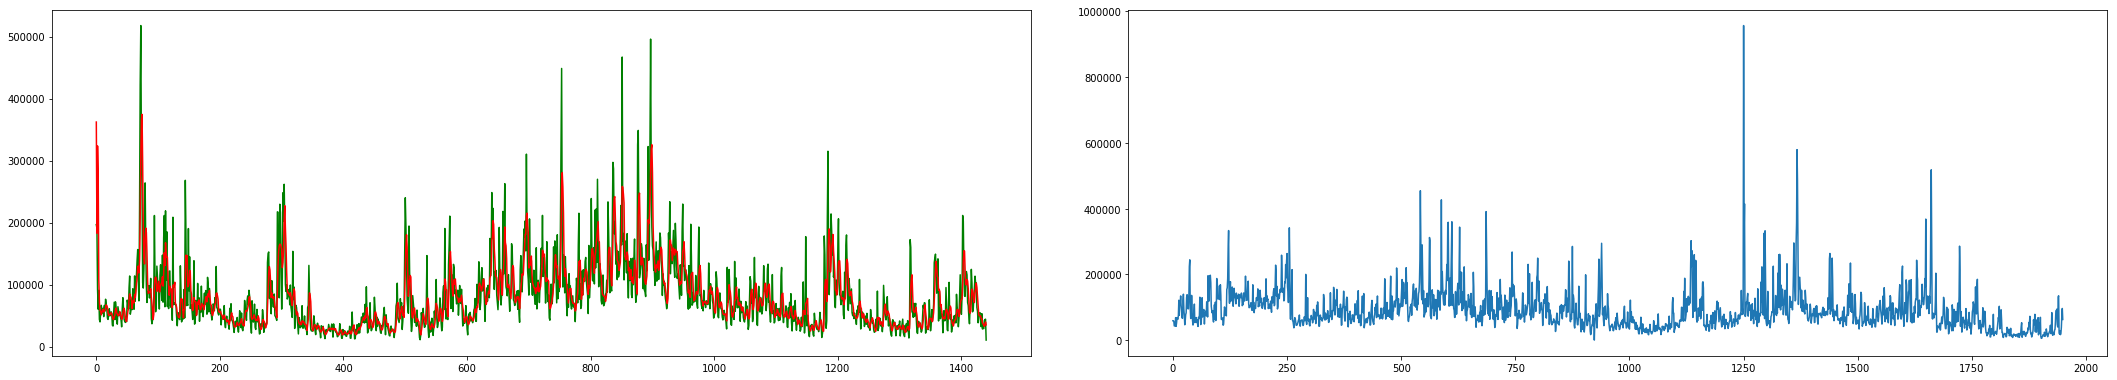

In [33]:
# hourly -- volume -- per day
# USD 

#cryptocompare api key:1 e3c9fe62074dbf5805d45f528d1e60c7ae15be68a63ba57ca3a5f2f9dbbf66f

#close,high,low,open,time,volumefrom,volumeto

def posix2Human(time_):
    timestamp = time_
    dt_object = datetime.fromtimestamp(timestamp)
    return dt_object

histPriceDay = cryptocompare.get_historical_price_day('BTC', curr='USD')

# Getting CryptoCompare BTC volume data -- 2000 API calls back 
vol = []
for idx, item in enumerate(histPriceDay['Data']):
    vol.append(item['volumefrom'])    

# -- Init subplots --
f,arr = plt.subplots(1,2)
  
arr[0].plot(np.array(vol),'g')

# Testing moving average

rolling_amnt = 4
df = pd.DataFrame(vol).rolling(rolling_amnt).mean()
print(df)

min_vol = np.nanmin(df.values)
max_vol = np.nanmax(df.values)

print(min_vol)
print(max_vol)

test = df.values


for i in range(rolling_amnt):
    rand_num = np.random.randint(low=min_vol,high=max_vol)
    test[i] = rand_num

arr[0].plot(test,color='r')
print(arr)

def fetch_latest_BTC_JSON():
    """Fetch the latest JSON data"""
    API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
    page = requests.get(API_LINK).json()
    return page

page = fetch_latest_BTC_JSON()

vol2 = []
for key,value in page['Time Series (Digital Currency Daily)'].items():
    vol2.append(float(value['5. volume']))
    
arr[1].plot(np.array(vol2))

plt.tight_layout()
f.set_figheight(5)
f.set_figwidth(30)

plt.show()



1441
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[6.0, 4.0]


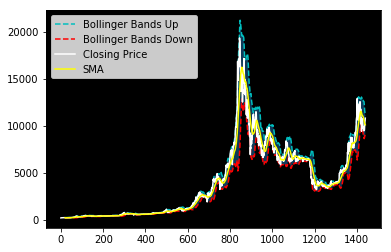

In [5]:
histPriceDay

close_prices = []
for idx,item in enumerate(histPriceDay['Data']):
    close_prices.append(item['close'])

print(len(close_prices))

# Calc SMA
sma = pd.DataFrame(close_prices).rolling(21).sum() / 21

# B-Bands
std = pd.DataFrame(close_prices).rolling(21).std()
lower_band = sma + (std * 2)
upper_band = sma - (std * 2)

print(type(lower_band.values))
print(type(upper_band.values))
lower_band = lower_band.values.flatten()
upper_band = upper_band.values.flatten()

plt.plot(lower_band,'c--')
plt.plot(upper_band,'r--')
x = np.arange(1441)
plt.fill_between(x,np.array(lower_band),np.array(upper_band),interpolate=True,alpha=0.5)
plt.plot(close_prices,'white')
plt.plot(sma,'yellow')
fig_size = plt.rcParams["figure.figsize"]
print(fig_size)
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
fig_size = plt.rcParams["figure.figsize"]
ax = plt.gca()
ax.set_facecolor((0, 0, 0))
plt.legend(['Bollinger Bands Up','Bollinger Bands Down','Closing Price','SMA'])
plt.show()

In [6]:
print('CryptoCompare last reported volume (yesterday): ', vol[-1])

CryptoCompare last reported volume (yesterday):  10481.64


## Config file with Model Hyperparameters

In [7]:
def get_config(file_loc='/content/gdrive/My Drive/College/Undergraduate Research/StockData/config.yaml'):
    return yaml.safe_load(open(file_loc))
config = get_config()
print(type(config))
print(config)

<class 'dict'>
{'learning_rate': 0.001, 'batch_size': 1, 'epochs': 100, 'dropout_rate': 0, 'lstm_hidden_size': 1, 'lstm_num_layers': 1}


## Neural network architectures

* 3 Layer Multi-Layer Perceptron
* 1 Layer Temporal Convolutional Neural Network
* Long-Term-Short-Term Recurrent Neural Network

In [0]:
"""
Basic multilayer perceptron subclass 
of three layers in PyTorch
"""
class MLP(nn.Module):
    def __init__(self,num_features):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=num_features,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

class NumberRegression_MLP(nn.Module):
    def __init__(self):
        super(NumberRegression_MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=1,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
"""
Recurrent Neural Networks (RNN)
RNNs are an excellent method to model sequential data
and time series data. This is perfect for stocks and
crytocurrency price prediction.

https://stackoverflow.com/questions/45022734/understanding-a-simple-lstm-pytorch
https://www.jessicayung.com/lstms-for-time-series-in-pytorch/
"""
class TestRNN(nn.Module):
    def __init__(self,bat_size,in_features,h_size,layer_amnt):
        super(TestRNN,self).__init__()
        
        self.batch_sz = bat_size
        self.in_features = in_features
        self.h_size = h_size
        self.layer_amnt = layer_amnt
        
        self.lstm1 = nn.LSTM(input_size=self.in_features,
                             hidden_size=self.h_size,
                             num_layers=self.layer_amnt,
                             bias=True,
                             batch_first=True,
                             dropout=0,
                             bidirectional=False
                            )
    def init_hidden(self):
        """Intialize/re-init the hidden and cell states. 
        The hidden state acts as the memory of the RNN 
        which gets passed from one unit to another. 
        h_i = f(h_i + in)

        Intializing with 0s
        """
        #print('layer size =\t', self.layer_amnt)
        #print('bat_size =\t', self.batch_sz)
        #print('hidden size =\t',self.h_size)
        return (torch.zeros(self.layer_amnt,self.batch_sz,self.h_size),
                torch.zeros(self.layer_amnt,self.batch_sz,self.h_size))
    def forward(self,x):
        x = x.unsqueeze(0)
        hidden_init = self.init_hidden()
        h0 = hidden_init[0].to(device)
        c0 = hidden_init[1].to(device)
        x,hidden = self.lstm1( x,(h0,c0))
        return x
      
"""
Temporal Convolutional Neural Network (CNN)
Time series based convolutional neural network
"""
class TimeCNN(nn.Module):
    def __init__(self):
        super(TimeCNN,self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=256,kernel_size=2,stride=1,padding=0)
        self.fc1 = nn.Linear(in_features=512,out_features=1024)
        self.fc2 = nn.Linear(in_features=1024,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    def forward(self,x):
        x = x.unsqueeze(0)
        x = F.leaky_relu(self.conv1(x))
        x = x.reshape(-1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

"""
https://arxiv.org/pdf/1506.00019.pdf
https://www.quora.com/How-is-the-hidden-state-h-different-from-the-memory-c-in-an-LSTM-cell
"""
class TimeRNN(nn.Module):
    def __init__(self,bat_size,in_features,h_size,layer_amnt):
        super(TimeRNN,self).__init__()
        
        self.batch_sz = bat_size
        self.in_features = in_features
        self.h_size = h_size
        self.layer_amnt = layer_amnt
        
        self.lstm1 = nn.LSTM(input_size=self.in_features,
                             hidden_size=self.h_size,
                             num_layers=self.layer_amnt,
                             bias=True,
                             batch_first=True,
                             dropout=0,
                             bidirectional=False)
        self.fc1 = nn.Linear(in_features=1,out_features=1)
    def init_hidden(self):
        """Intialize/re-init the hidden and cell states. 
        The hidden state acts as the memory of the RNN 
        which gets passed from one unit to another. 
        h_i = f(h_i + in)

        Intializing with 0s
        """
        #print('layer size =\t', self.layer_amnt)
        #print('bat_size =\t', self.batch_sz)
        #print('hidden size =\t',self.h_size)
        return (torch.zeros(self.layer_amnt,self.batch_sz,self.h_size),
                torch.zeros(self.layer_amnt,self.batch_sz,self.h_size))
    def forward(self,x):
        x = x.unsqueeze(0)
        hidden_init = self.init_hidden()
        h0 = hidden_init[0].to(device)
        c0 = hidden_init[1].to(device)
        x,hidden = self.lstm1( x,(h0,c0))
        x = F.leaky_relu(self.fc1(x[-1].view(self.batch_sz,-1)))
        return x

In [0]:
class TickerData(torch.utils.data.Dataset):
    def __init__(self, table):
        self.dataset = table
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        """idx --> data pointer"""
        return self.dataset[idx]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device state:\t", device)
print("Device index:\t",torch.cuda.current_device())
print("Current device:\t", torch.cuda.get_device_name(device))

Device state:	 cuda
Device index:	 0
Current device:	 Tesla K80


## Training Phase

In [0]:
class Trainer(object):
    def __init__(self):
        pass
    def fetch_latest_BTC_JSON(self):
        """Fetch the latest JSON data"""
        API_LINK = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=USD&apikey=SAITMI5ZUMGEKGKY'
        page = requests.get(API_LINK).json()
        return page
    def fetch_btc_prices(self):
        with open("/content/gdrive/My Drive/College/Undergraduate Research/StockData/BTC_data.json") as f:
            return json.load(f)  

    def parse_alphaV_JSON(self,raw_data):
        # Remove meta data for now
        raw_data.pop('Meta Data',None)
        # Remove key name
        df = pd.DataFrame.from_dict(raw_data['Time Series (Digital Currency Daily)'],dtype=float)
        # Flip dates as columns into rows
        df = df.transpose()
        return df
    
    def data_split(self,x_train,y_train):
        x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=100,shuffle=False)
        return x_train, x_test, y_train, y_test

    def train(self,model, x_data,y_data, original_prices,epochs):
        """Price prediction model training loop function. This method
        is generalized for the purposes of allowing any model to be used

        Arguements:"""
        prices = torch.tensor(original_prices)
        max_price = torch.max(prices)
        min_price = torch.min(prices)

        print('----Dataset Prep----')
        x_train, x_test, y_train, y_test = self.data_split(x_data,y_data)
        train_tensorDataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
        train_data_loader = torch.utils.data.DataLoader(
            dataset=train_tensorDataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=0
        )

        test_tensorDataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
        test_data_loader = torch.utils.data.DataLoader(
            dataset=test_tensorDataset,
            batch_size=config['batch_size'],
            shuffle=False,
            num_workers=0
        )

        print('-- Model Architecture --')
        print(model)

        # -- Model to CUDA GPU --
        if( str(device) == 'cuda'):
            print('Sending model to',torch.cuda.get_device_name(device),' GPU')
            #model = model.cuda()
            model.to(device)

        # -- Since we are predicting prices --> mean squared error is our loss function
        loss_func = torch.nn.MSELoss()

        # -- Optimizer --> Adam generally works best
        # TODO: choose a better learning rate later
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

        total_loss = 0
        losses = []
        for epoch in (range(epochs)):
            for i, (examples,labels) in tqdm(enumerate(train_data_loader)):

                if( str(device) == 'cuda'):
                    examples = examples.to(device)
                    labels = labels.to(device)

                #print(examples , " ----- " , labels)

                optimizer.zero_grad()

                # -- Input to CUDA --
                #examples = examples.to(device)
                #labels = labels.to(device)

                y_predictions = model(examples.float())
                loss = loss_func(y_predictions.float(),labels.view(1,1).float())

                total_loss += loss.data

                # back-prop to update the weights
                loss.backward()
                # optimizer steps based on lr
                optimizer.step()

                y_preds = y_predictions.cpu().detach().numpy()
                y_preds = torch.tensor(y_preds)
                #print(y_preds.shape)
                test = self.un_normalize(y_preds, min_price, max_price)
                #print("---> ", test)
                #break

            print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, config['epochs'], loss.data))
            #print(list(model.parameters()))
            print("-----------------------------------------------------------------------------")
            losses.append(loss.data)
        return losses, test_data_loader, loss_func, model, min_price, max_price, y_test


    def table_edit(self,dataframe):
        dataframe = dataframe.drop(labels=['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
        table_col_order = ['1a. open (USD)','2a. high (USD)','3a. low (USD)','5. volume','6. market cap (USD)','4a. close (USD)']
        dataframe = dataframe[table_col_order]
        return dataframe

    def loss_visualize(self,loss_tensor):
        losses = np.array(loss_tensor)
        print(losses)

        plt.plot(losses)

    def validation_test(self,test_dataloader, criterion, model, norm_min, norm_max):
        test_loss = 0
        accuracy = 0
        all_predictions = []
        for (examples, labels) in test_dataloader:

            if(str(device) == 'cuda'):
                examples = examples.to(device)
                labels = labels.to(device)

            output = model.forward(examples)

            un_normed_outputs = self.un_normalize(output, norm_min,norm_max)
            all_predictions.append(un_normed_outputs.detach())
            #print("output --> ", un_normed_outputs)
            loss = criterion(output, labels.view(1,1)).item()
            test_loss += loss

            #ps = torch.exp(output)
            #equality = (labels.data == ps.max(dim=1)[1])
            #accuracy += equality.type(torch.FloatTensor).mean()

            #print('output --> ', un_normed_outputs, ' loss --> ', loss)

        return test_loss, accuracy, all_predictions

    def un_normalize(self,norm_val,min_val,max_val,typelist=None):
        if(typelist):
            for idx,item in enumerate(norm_val):
                new_val = item * (max_val - min_val) + min_val
                norm_val[idx] = new_val
            return norm_val
        else:
            return norm_val * (max_val - min_val) + min_val  

    def prediction_visualization(self,minimum_price,maximum_price,close_prices,model_predictions):
        plt.close()

        test_values = np.array(self.un_normalize(norm_val=close_prices,min_val=minimum_price,max_val=maximum_price,typelist=True))
        print(test_values)
        #print(np.array(model_predictions.grad))
        #model_predictions[0].requires_grad = False
        print(model_predictions) ###
        print(len(model_predictions))
        for idx,item in enumerate(model_predictions):
            print('the item is =\t',item)
            print('the size of the item is =\t', item.shape)
            model_predictions[idx] = np.asscalar(item.cpu().numpy())
        predicted_values = model_predictions

        print(len(test_values))
        print(len(predicted_values))

        f, ax = plt.subplots()

        ax.plot(np.array(test_values),color='#FFA500')
        ax.plot(np.array(predicted_values),color='g')
        plt.show()
        return np.array(test_values),np.array(predicted_values)

    def volume_visualization(self,volume):
        vol = np.array(volume)
        plt.plot(vol)
        pass

    def VMA_calculation(self,prices=[]):
        prices = np.array(prices)

        n_prices = []
        for idx, p in enumerate(prices):
            if(idx + 1 == len(prices)):
                break
            p1 = prices[idx]
            p2 = prices[idx+1]
            arr = np.array([p1,p2])#,p3,p4,p5,p6,p7,p8,p9,p10,p11])
            n_prices.append(arr)

        vmas = []
        for arr in n_prices:
            sum_vol = arr.sum()
            vmas.append(sum_vol/2)

        first_ten = vmas[:10]
        average_num = np.average(first_ten)
        vmas = np.insert(vmas,0,average_num)

        #plt.figure(figsize=(20,10))
        #plt.plot(np.array(prices))
        #plt.plot(np.array(vmas))
        return vmas


    def vol_dataset_prep(self,vma,volume,original_volume):
        """VMA - x_train -- volume -- y_train"""
        print(len(vma))
        print(len(volume))
        print(len(original_volume))

    #     vma = torch.tensor(vma)
    #     volume = torch.tensor(volume)


        #########################
        x_train,x_test,y_train,y_test = data_split(volume,volume)

        #######################

        #x_train,x_test,y_train,y_test = data_split(vma,volume)

        train_data = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
        test_data = torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))
        train_dataloader = torch.utils.data.DataLoader(
            dataset=train_data,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )
        test_dataloader = torch.utils.data.DataLoader(
            dataset=test_data,
            batch_size=1,
            shuffle=False,
            num_workers=0
        )
        return x_train,y_train,x_test,y_test,train_dataloader,test_dataloader

    def vol_train(self,model, train_dataloader):
        loss_func = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

        total_loss = 0
        losses = []
        for epoch in (range(10)):
            for i, (examples,labels) in tqdm(enumerate(train_dataloader)):

                optimizer.zero_grad()

                y_predictions = model(examples.float())
                loss = loss_func(y_predictions.float(),labels.float())

                total_loss += loss.data

                # back-prop to update the weights
                loss.backward()
                # optimizer steps based on lr
                optimizer.step()

                y_preds = y_predictions.cpu().detach().numpy()
                y_preds = torch.tensor(y_preds)
                #print(y_preds.shape)
                #print("---> ", test)
                #break

            print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
            #print(list(model.parameters()))
            print("-----------------------------------------------------------------------------")
            losses.append(loss.data)
        return model,loss_func,total_loss,losses

    def vol_test(self,model,criterion,test_dataloader,min_val,max_val):
        test_loss = 0
        accuracy = 0
        all_predictions = []
        for (examples, labels) in test_dataloader:
            output = model.forward(examples.float())
            un_normed_outputs = self.un_normalize(output, min_val,max_val)
            all_predictions.append(un_normed_outputs.detach())
            loss = criterion(output, labels.float()).item()
            test_loss += loss
        return test_loss, accuracy, all_predictions

    def vol_prediction_visualization(self,predictions,actual,min_val,max_val):
        for idx,item in enumerate(predictions):
              predictions[idx] = np.asscalar(item.numpy())
        print(predictions)
        actual = self.un_normalize(actual,min_val,max_val,typelist=True)
        print(actual)
        plt.figure(figsize=(20,10))
        plt.plot(np.array(actual),color='g')
        plt.plot(np.array(predictions),color='#FFA500')

30it [00:00, 299.72it/s]

---new---
      2a. high (USD)  3a. low (USD)  5. volume
0           0.014211       0.015871   0.065599
1           0.014355       0.013845   0.100519
2           0.012236       0.012991   0.077509
3           0.012484       0.013762   0.040911
4           0.012945       0.014617   0.022424
5           0.013249       0.014911   0.017252
6           0.012887       0.014522   0.029798
7           0.012805       0.014599   0.019009
8           0.012839       0.014362   0.024194
9           0.012070       0.009860   0.140818
10          0.011075       0.009354   0.137174
11          0.011771       0.012994   0.041614
12          0.011221       0.011829   0.049542
13          0.013162       0.012539   0.098314
14          0.015952       0.015069   0.092624
15          0.017025       0.017238   0.092662
16          0.016395       0.016630   0.058510
17          0.014684       0.015970   0.033406
18          0.015022       0.015944   0.031836
19          0.015335       0.017046   0.017060
20 

1560it [00:05, 303.37it/s]
32it [00:00, 311.15it/s]

Epoch [1/100], Loss: 4.497082773013972e-05
-----------------------------------------------------------------------------


1560it [00:05, 307.09it/s]
32it [00:00, 314.97it/s]

Epoch [2/100], Loss: 0.00010705997556215152
-----------------------------------------------------------------------------


1560it [00:05, 306.59it/s]
32it [00:00, 315.87it/s]

Epoch [3/100], Loss: 3.773210119106807e-05
-----------------------------------------------------------------------------


1560it [00:05, 305.92it/s]
32it [00:00, 314.26it/s]

Epoch [4/100], Loss: 1.0202218163612997e-06
-----------------------------------------------------------------------------


1560it [00:05, 302.03it/s]
30it [00:00, 294.55it/s]

Epoch [5/100], Loss: 1.0750281035143416e-05
-----------------------------------------------------------------------------


1560it [00:05, 289.56it/s]
30it [00:00, 292.04it/s]

Epoch [6/100], Loss: 3.1964427762432024e-05
-----------------------------------------------------------------------------


1560it [00:05, 294.42it/s]
30it [00:00, 299.20it/s]

Epoch [7/100], Loss: 3.719617234310135e-05
-----------------------------------------------------------------------------


1560it [00:05, 307.79it/s]
31it [00:00, 308.66it/s]

Epoch [8/100], Loss: 2.6767305826069787e-05
-----------------------------------------------------------------------------


1560it [00:05, 306.11it/s]
31it [00:00, 307.66it/s]

Epoch [9/100], Loss: 1.3025538464717101e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.02it/s]
32it [00:00, 314.89it/s]

Epoch [10/100], Loss: 3.564120106602786e-06
-----------------------------------------------------------------------------


1560it [00:05, 308.99it/s]
32it [00:00, 313.91it/s]

Epoch [11/100], Loss: 9.708413983844366e-08
-----------------------------------------------------------------------------


1560it [00:05, 311.54it/s]
32it [00:00, 316.17it/s]

Epoch [12/100], Loss: 9.100063493860944e-07
-----------------------------------------------------------------------------


1560it [00:05, 309.76it/s]
33it [00:00, 322.69it/s]

Epoch [13/100], Loss: 3.5254040540166898e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.45it/s]
29it [00:00, 280.16it/s]

Epoch [14/100], Loss: 6.336113528959686e-06
-----------------------------------------------------------------------------


1560it [00:05, 309.73it/s]
32it [00:00, 319.97it/s]

Epoch [15/100], Loss: 8.745355444261804e-06
-----------------------------------------------------------------------------


1560it [00:05, 308.05it/s]
32it [00:00, 310.47it/s]

Epoch [16/100], Loss: 1.065804190147901e-05
-----------------------------------------------------------------------------


1560it [00:05, 309.82it/s]
31it [00:00, 308.67it/s]

Epoch [17/100], Loss: 1.2141237675677985e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.17it/s]
31it [00:00, 307.59it/s]

Epoch [18/100], Loss: 1.3287349247548264e-05
-----------------------------------------------------------------------------


1560it [00:05, 307.00it/s]
32it [00:00, 313.18it/s]

Epoch [19/100], Loss: 1.4169517271511722e-05
-----------------------------------------------------------------------------


1560it [00:05, 306.83it/s]
30it [00:00, 291.82it/s]

Epoch [20/100], Loss: 1.4845327314105816e-05
-----------------------------------------------------------------------------


1560it [00:05, 293.54it/s]
33it [00:00, 326.41it/s]

Epoch [21/100], Loss: 1.535626688564662e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.97it/s]
32it [00:00, 310.26it/s]

Epoch [22/100], Loss: 1.5734149201307446e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.88it/s]
33it [00:00, 327.12it/s]

Epoch [23/100], Loss: 1.6006264559109695e-05
-----------------------------------------------------------------------------


1560it [00:05, 309.70it/s]
32it [00:00, 317.73it/s]

Epoch [24/100], Loss: 1.6188731024158187e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.76it/s]
32it [00:00, 318.28it/s]

Epoch [25/100], Loss: 1.6302845324389637e-05
-----------------------------------------------------------------------------


1560it [00:05, 308.59it/s]
31it [00:00, 309.84it/s]

Epoch [26/100], Loss: 1.635896842344664e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.06it/s]
32it [00:00, 313.23it/s]

Epoch [27/100], Loss: 1.63681306730723e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.15it/s]
29it [00:00, 285.72it/s]

Epoch [28/100], Loss: 1.6338000932591967e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.11it/s]
32it [00:00, 316.58it/s]

Epoch [29/100], Loss: 1.6278067050734535e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.69it/s]
33it [00:00, 323.29it/s]

Epoch [30/100], Loss: 1.6190888345590793e-05
-----------------------------------------------------------------------------


1560it [00:05, 309.30it/s]
30it [00:00, 294.76it/s]

Epoch [31/100], Loss: 1.6084337403299287e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.53it/s]
31it [00:00, 308.19it/s]

Epoch [32/100], Loss: 1.5958607036736794e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.10it/s]
33it [00:00, 322.89it/s]

Epoch [33/100], Loss: 1.5816771337995306e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.02it/s]
32it [00:00, 318.97it/s]

Epoch [34/100], Loss: 1.5664008969906718e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.69it/s]
32it [00:00, 318.89it/s]

Epoch [35/100], Loss: 1.5500250810873695e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.46it/s]
30it [00:00, 296.72it/s]

Epoch [36/100], Loss: 1.532685200800188e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.87it/s]
32it [00:00, 319.81it/s]

Epoch [37/100], Loss: 1.5144914868869819e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.63it/s]
32it [00:00, 318.28it/s]

Epoch [38/100], Loss: 1.4954614016460255e-05
-----------------------------------------------------------------------------


1560it [00:05, 312.00it/s]
33it [00:00, 326.43it/s]

Epoch [39/100], Loss: 1.4758416000404395e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.11it/s]
32it [00:00, 319.00it/s]

Epoch [40/100], Loss: 1.4556462701875716e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.66it/s]
33it [00:00, 323.70it/s]

Epoch [41/100], Loss: 1.4347320757224225e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.15it/s]
31it [00:00, 308.45it/s]

Epoch [42/100], Loss: 1.4134761840978172e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.22it/s]
30it [00:00, 299.85it/s]

Epoch [43/100], Loss: 1.3917117939854506e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.57it/s]
32it [00:00, 319.81it/s]

Epoch [44/100], Loss: 1.36965290948865e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.39it/s]
33it [00:00, 321.69it/s]

Epoch [45/100], Loss: 1.3471576494339388e-05
-----------------------------------------------------------------------------


1560it [00:04, 312.00it/s]
33it [00:00, 324.28it/s]

Epoch [46/100], Loss: 1.3245883565105032e-05
-----------------------------------------------------------------------------


1560it [00:05, 309.01it/s]
32it [00:00, 313.76it/s]

Epoch [47/100], Loss: 1.30143544083694e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.87it/s]
32it [00:00, 315.95it/s]

Epoch [48/100], Loss: 1.2782736121152993e-05
-----------------------------------------------------------------------------


1560it [00:05, 309.25it/s]
32it [00:00, 319.24it/s]

Epoch [49/100], Loss: 1.2550029168778565e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.95it/s]
33it [00:00, 316.56it/s]

Epoch [50/100], Loss: 1.2316741049289703e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.31it/s]
33it [00:00, 320.74it/s]

Epoch [51/100], Loss: 1.2082740795449354e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.52it/s]
30it [00:00, 295.56it/s]

Epoch [52/100], Loss: 1.1848726899188478e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.13it/s]
33it [00:00, 324.43it/s]

Epoch [53/100], Loss: 1.1613143215072341e-05
-----------------------------------------------------------------------------


1560it [00:05, 310.59it/s]
32it [00:00, 318.81it/s]

Epoch [54/100], Loss: 1.1382337106624618e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.54it/s]
33it [00:00, 318.62it/s]

Epoch [55/100], Loss: 1.115086161007639e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.73it/s]
32it [00:00, 319.18it/s]

Epoch [56/100], Loss: 1.0921961802523583e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.26it/s]
33it [00:00, 324.42it/s]

Epoch [57/100], Loss: 1.0695630408008583e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.70it/s]
33it [00:00, 321.44it/s]

Epoch [58/100], Loss: 1.0471475434314925e-05
-----------------------------------------------------------------------------


1560it [00:04, 315.63it/s]
29it [00:00, 286.73it/s]

Epoch [59/100], Loss: 1.025007622956764e-05
-----------------------------------------------------------------------------


1560it [00:05, 311.17it/s]
33it [00:00, 321.21it/s]

Epoch [60/100], Loss: 1.0034063961938955e-05
-----------------------------------------------------------------------------


1560it [00:04, 313.56it/s]
32it [00:00, 319.10it/s]

Epoch [61/100], Loss: 9.819791557674762e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.22it/s]
33it [00:00, 320.75it/s]

Epoch [62/100], Loss: 9.610233064449858e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.52it/s]
33it [00:00, 324.75it/s]

Epoch [63/100], Loss: 9.404579941474367e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.40it/s]
31it [00:00, 306.74it/s]

Epoch [64/100], Loss: 9.204044545185752e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.68it/s]
32it [00:00, 316.73it/s]

Epoch [65/100], Loss: 9.006922482512891e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.98it/s]
30it [00:00, 297.79it/s]

Epoch [66/100], Loss: 8.814587999950163e-06
-----------------------------------------------------------------------------


1560it [00:05, 304.81it/s]
29it [00:00, 280.61it/s]

Epoch [67/100], Loss: 8.627830538898706e-06
-----------------------------------------------------------------------------


1560it [00:05, 298.95it/s]
30it [00:00, 291.51it/s]

Epoch [68/100], Loss: 8.44584428705275e-06
-----------------------------------------------------------------------------


1560it [00:05, 307.77it/s]
29it [00:00, 289.76it/s]

Epoch [69/100], Loss: 8.268711098935455e-06
-----------------------------------------------------------------------------


1560it [00:04, 315.41it/s]
29it [00:00, 289.69it/s]

Epoch [70/100], Loss: 8.094981239992194e-06
-----------------------------------------------------------------------------


1560it [00:04, 320.06it/s]
33it [00:00, 322.00it/s]

Epoch [71/100], Loss: 7.928130798973143e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.27it/s]
33it [00:00, 325.81it/s]

Epoch [72/100], Loss: 7.764843758195639e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.71it/s]
32it [00:00, 313.84it/s]

Epoch [73/100], Loss: 7.607694442413049e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.47it/s]
31it [00:00, 308.24it/s]

Epoch [74/100], Loss: 7.455569175363053e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.55it/s]
29it [00:00, 284.57it/s]

Epoch [75/100], Loss: 7.307557552849175e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.26it/s]
32it [00:00, 314.72it/s]

Epoch [76/100], Loss: 7.164380349422572e-06
-----------------------------------------------------------------------------


1560it [00:04, 312.46it/s]
32it [00:00, 319.54it/s]

Epoch [77/100], Loss: 7.0257788138405886e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.82it/s]
33it [00:00, 324.10it/s]

Epoch [78/100], Loss: 6.8922859099984635e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.92it/s]
33it [00:00, 322.36it/s]

Epoch [79/100], Loss: 6.76332865623408e-06
-----------------------------------------------------------------------------


1560it [00:04, 316.00it/s]
33it [00:00, 323.88it/s]

Epoch [80/100], Loss: 6.638660124735907e-06
-----------------------------------------------------------------------------


1560it [00:05, 311.83it/s]
30it [00:00, 293.12it/s]

Epoch [81/100], Loss: 6.518194823001977e-06
-----------------------------------------------------------------------------


1560it [00:05, 305.12it/s]
29it [00:00, 284.50it/s]

Epoch [82/100], Loss: 6.403205588867422e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.35it/s]
33it [00:00, 320.57it/s]

Epoch [83/100], Loss: 6.29222950010444e-06
-----------------------------------------------------------------------------


1560it [00:04, 315.55it/s]
32it [00:00, 314.44it/s]

Epoch [84/100], Loss: 6.185039637784939e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.10it/s]
33it [00:00, 326.96it/s]

Epoch [85/100], Loss: 6.081710125727113e-06
-----------------------------------------------------------------------------


1560it [00:04, 316.25it/s]
32it [00:00, 317.81it/s]

Epoch [86/100], Loss: 5.983332812320441e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.91it/s]
32it [00:00, 318.24it/s]

Epoch [87/100], Loss: 5.887492989131715e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.70it/s]
28it [00:00, 276.48it/s]

Epoch [88/100], Loss: 5.797161975351628e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.24it/s]
32it [00:00, 315.91it/s]

Epoch [89/100], Loss: 5.7085258049482945e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.58it/s]
33it [00:00, 323.11it/s]

Epoch [90/100], Loss: 5.624671757686883e-06
-----------------------------------------------------------------------------


1560it [00:05, 311.07it/s]
33it [00:00, 327.42it/s]

Epoch [91/100], Loss: 5.542700364458142e-06
-----------------------------------------------------------------------------


1560it [00:04, 315.77it/s]
33it [00:00, 320.09it/s]

Epoch [92/100], Loss: 5.464674813993042e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.04it/s]
31it [00:00, 308.66it/s]

Epoch [93/100], Loss: 5.3883086366113275e-06
-----------------------------------------------------------------------------


1560it [00:04, 315.93it/s]
28it [00:00, 279.57it/s]

Epoch [94/100], Loss: 5.3170147111814e-06
-----------------------------------------------------------------------------


1560it [00:04, 316.14it/s]
33it [00:00, 323.38it/s]

Epoch [95/100], Loss: 5.24578581462265e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.46it/s]
33it [00:00, 321.93it/s]

Epoch [96/100], Loss: 5.178427727514645e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.77it/s]
33it [00:00, 328.67it/s]

Epoch [97/100], Loss: 5.113930910738418e-06
-----------------------------------------------------------------------------


1560it [00:04, 315.09it/s]
31it [00:00, 306.52it/s]

Epoch [98/100], Loss: 5.050909749115817e-06
-----------------------------------------------------------------------------


1560it [00:04, 314.93it/s]
31it [00:00, 306.92it/s]

Epoch [99/100], Loss: 4.990942215954419e-06
-----------------------------------------------------------------------------


1560it [00:04, 313.61it/s]


Epoch [100/100], Loss: 4.9321270125801675e-06
-----------------------------------------------------------------------------
[tensor(4.4971e-05, device='cuda:0') tensor(0.0001, device='cuda:0')
 tensor(3.7732e-05, device='cuda:0') tensor(1.0202e-06, device='cuda:0')
 tensor(1.0750e-05, device='cuda:0') tensor(3.1964e-05, device='cuda:0')
 tensor(3.7196e-05, device='cuda:0') tensor(2.6767e-05, device='cuda:0')
 tensor(1.3026e-05, device='cuda:0') tensor(3.5641e-06, device='cuda:0')
 tensor(9.7084e-08, device='cuda:0') tensor(9.1001e-07, device='cuda:0')
 tensor(3.5254e-06, device='cuda:0') tensor(6.3361e-06, device='cuda:0')
 tensor(8.7454e-06, device='cuda:0') tensor(1.0658e-05, device='cuda:0')
 tensor(1.2141e-05, device='cuda:0') tensor(1.3287e-05, device='cuda:0')
 tensor(1.4170e-05, device='cuda:0') tensor(1.4845e-05, device='cuda:0')
 tensor(1.5356e-05, device='cuda:0') tensor(1.5734e-05, device='cuda:0')
 tensor(1.6006e-05, device='cuda:0') tensor(1.6189e-05, device='cuda:0')
 ten

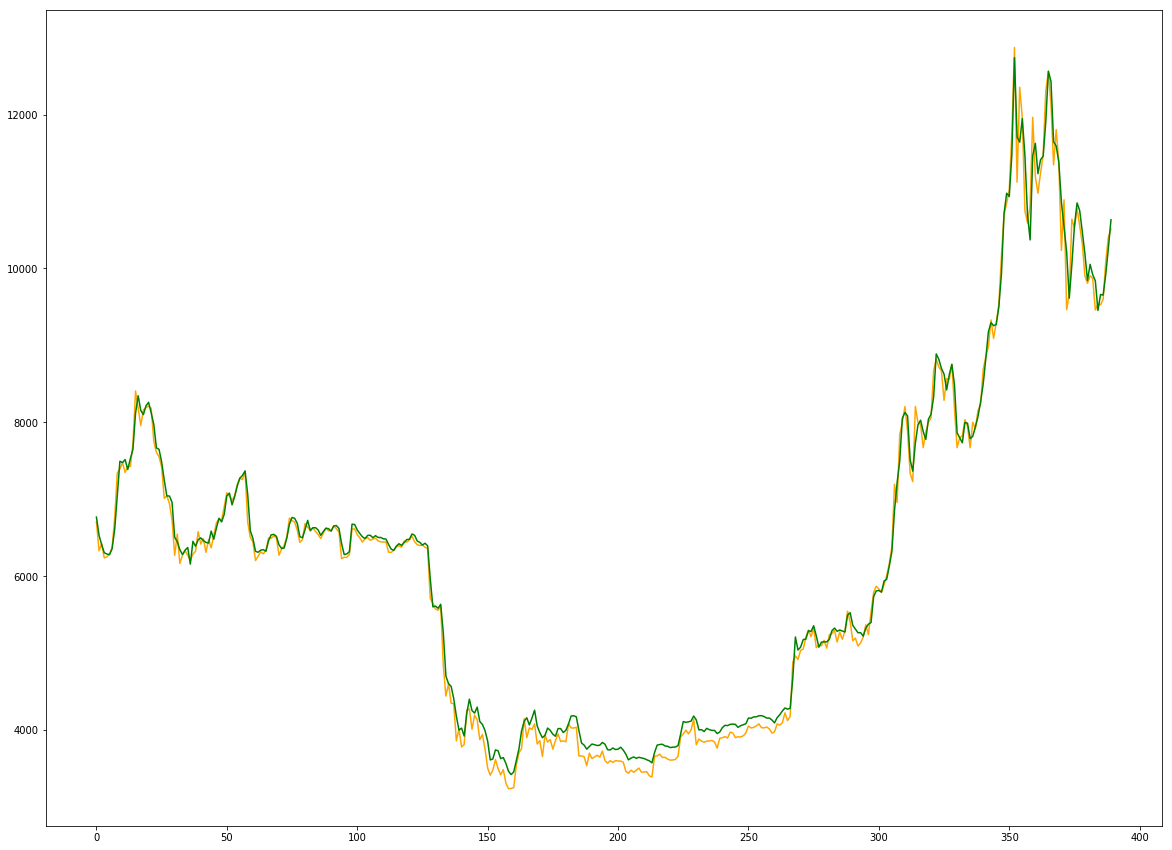

In [60]:
def main():

    trainer = Trainer()

    # -- Preprocessing -- #
    raw_price_data = trainer.fetch_latest_BTC_JSON()
    data_df = trainer.parse_alphaV_JSON(raw_data=raw_price_data)
    data_df = data_df.iloc[::-1] # Flip data

    # Seperating the y-data
    prices = np.array(data_df['4a. close (USD)'].tolist())
   
    # Temporary dataframe for creating an extra normalizer for re-scaling inference values later
    data_df_temp = data_df.drop(labels=['1a. open (USD)','1b. open (USD)','2b. high (USD)','3b. low (USD)','4a. close (USD)','4b. close (USD)','6. market cap (USD)'],axis=1) # ,'2a. high (USD)','3a. low (USD)'
    minmax_2 = preprocessing.MinMaxScaler()
    data_df_temp = pd.DataFrame(minmax_2.fit_transform(data_df_temp), columns=data_df_temp.columns)
    
    # -- Normalize the Data --
    min_max_scaler = preprocessing.MinMaxScaler()
    data_df = pd.DataFrame(min_max_scaler.fit_transform(data_df), columns=data_df.columns)
    data_df = trainer.table_edit(data_df)
    y_train = np.array(data_df['4a. close (USD)'].tolist())
    data_df = data_df.drop(labels=['4a. close (USD)'],axis=1)
    
    data_df = data_df.drop(labels=['1a. open (USD)','6. market cap (USD)'],axis=1)
    print('---new---')
    print(data_df)
 
    model = TimeRNN(bat_size=config['batch_size'],
                    in_features=3,
                    h_size=config['lstm_hidden_size'],
                    layer_amnt=config['lstm_num_layers']
                    ) 
    #model = TimeCNN()
    #model = MLP(3)

    losses, test_data_loader, loss_func, model, min_price, max_price, test_prices = trainer.train(model=model, 
                                                                                                  x_data=data_df.values,
                                                                                                  y_data=y_train,
                                                                                                  original_prices=prices,
                                                                                                  epochs=config['epochs']
                                                                                                  )
    trainer.loss_visualize(losses)
    _, _, all_unnormed_outputs = trainer.validation_test(test_dataloader=test_data_loader,criterion=loss_func, model=model, norm_min=min_price, norm_max=max_price)
    
    test_values,pred_values = trainer.prediction_visualization(minimum_price=min_price,
                                                               maximum_price=max_price,
                                                               close_prices=test_prices,
                                                               model_predictions=all_unnormed_outputs
                                                               )
    return minmax_2,model,min_price,max_price,test_values,pred_values

min_max_scaler,price_model,min_price,max_price,test_values,pred_values = main()

## Model Inference Testing

tensor(178.3485, dtype=torch.float64)
tensor(19394.7576, dtype=torch.float64)
BTC prediction:  [tensor([[10904.8301]], device='cuda:0'), tensor([[10993.2949]], device='cuda:0'), tensor([[10959.7188]], device='cuda:0')]
[10904.830078125, 10993.294921875, 10959.71875]


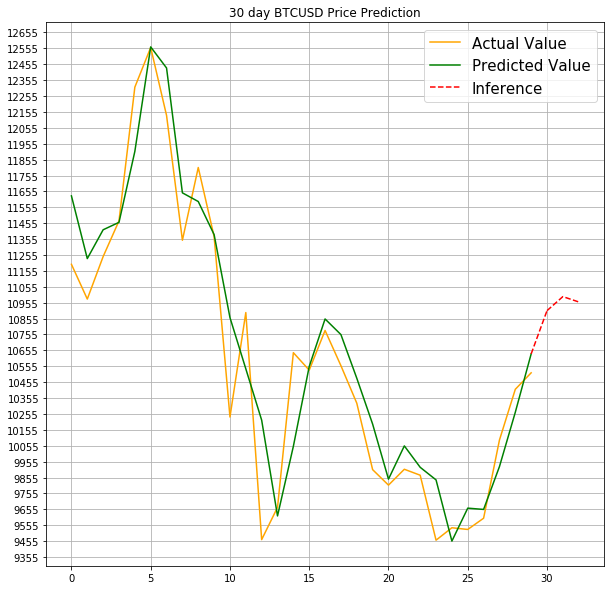

In [104]:
class Inferencer(object):
    def __init__(self):
        pass
    def un_normalize(self,norm_val,min_val,max_val,typelist=None):
        if(typelist):
            for idx,item in enumerate(norm_val):
                new_val = item * (max_val - min_val) + min_val
                norm_val[idx] = new_val
            return norm_val
        else:
            return norm_val * (max_val - min_val) + min_val 

    def inference(self,value, normalize_method, model,minimum_price,maximum_price):
        value = np.array(value)
        predictions = []
        for sample in value:
            sample = np.array(sample).reshape(1,-1)
            example = torch.tensor(normalize_method.transform(sample)).float()
            
            if(str(device) == 'cuda'):
                example = example.to(device)

            output = model(example)
            output_unnorm = self.un_normalize(norm_val=output.detach(),min_val=minimum_price,max_val=maximum_price)
            predictions.append(output_unnorm)
        return predictions
    
    def prediction_visualize(self,window=0,test_vals=[],pred_values=[],inference_values=[]):

        if(window == 0):
            plt.close()
            # --- visualize ---
            f,arr = plt.subplots()
            arr.plot(test_vals,'#FFA500')
            arr.plot(pred_values,'g')

            x_val = np.arange(len(pred_values),len(pred_values)+len(inference_values),1)
            # -- Connect --
            x = [x_val[0] - 1, x_val[0]]
            y = [pred_values[-1],inference_values[0]]
            arr.plot(x,y,'r')
            
            arr.plot(x_val,inference_values,'r')
            arr.grid()
        else:
            plt.close()
            test_vals = test_vals[-window:]
            pred_vals = pred_values[-window:]

            f,arr = plt.subplots()
            arr.plot(test_vals,'#FFA500')
            arr.plot(pred_vals,'g')

            x_val = np.arange(len(pred_vals),len(pred_vals)+len(inference_values),1)
            # -- Connect --
            x = [x_val[0] - 1, x_val[0]]
            y = [pred_values[-1],inference_values[0]]
            arr.plot(x,y,'r--')

            arr.plot(x_val,inference_values,'r--')
            arr.grid()

            start = min( np.min(test_vals),np.min(pred_vals),np.min(inference_values))
            end = max(( np.max(test_vals),np.max(pred_vals),np.max(inference_values)))

            plt.yticks(np.arange(start-100,end+100,100))
            arr.set_title(str(window) + ' day BTCUSD Price Prediction')
            arr.legend(['Actual Value','Predicted Value','Inference'],prop={'size': 15})

            fig_size[0] = 10
            fig_size[1] = 10
            plt.rcParams["figure.figsize"] = fig_size

            

def main(normalizer,model,minimum_price,maximum_price,test_vals,predicted_vals):
    inf = Inferencer()
    print(minimum_price)
    print(maximum_price)
    output = inf.inference(value=[[10300,11100,vol[-1]] ,
                                  [10500,11100,25000],
                                  [10400,11100,33424]
                                  ],
                       normalize_method=normalizer,
                       model=model,
                       minimum_price=minimum_price,
                       maximum_price=maximum_price
                      )
    print('BTC prediction: ', output)

    for idx,out in enumerate(output):
        output[idx] = np.asscalar(out.cpu())
    print(output)

    inf.prediction_visualize(window=30,
                             test_vals=test_vals,
                             pred_values=predicted_vals,
                             inference_values=output
                             )
    

    
main(normalizer=min_max_scaler,
     model=price_model,
     minimum_price=min_price,
     maximum_price=max_price,
     test_vals=test_values,
     predicted_vals=pred_values)

